<a href="https://colab.research.google.com/github/aniruddh-alt/FashionMNIST/blob/main/FashionMNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
# Convolution Neural Network for Fashion MNIST

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [59]:
class FashionCNN(nn.Module):
    def __init__(self):
      super(FashionCNN, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
      self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
      self.fc1 = nn.Linear(in_features = 16*7*7, out_features=128)
      self.fc2 = nn.Linear(in_features=128, out_features=10)
      self.relu = nn.ReLU()

    def forward(self, x):
      x = self.relu(self.conv1(x))
      x = self.pool(x)
      x = self.relu(self.conv2(x))
      x = self.pool(x)
      x = x.view(-1, 16*7*7)
      x = self.relu(self.fc1(x))
      x = self.fc2(x)
      return x





In [60]:
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test, batch_size=64, shuffle=False)


In [61]:
f = FashionCNN()
f.to(device)

FashionCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(f.parameters(), lr=0.001, weight_decay=1e-5)

In [63]:
from tqdm import tqdm

config = {
    'epochs': 100,
    'batch_size': 64,
    'learning_rate': 0.001
}

import numpy as np

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, model):
        # The score is negative because we want to minimize the validation loss
        score = -val_loss

        # If we don't have a best score yet, set it to the current score
        if self.best_score is None:
            self.best_score = score
            if self.verbose:
                print(f"Initial best validation loss: {val_loss}")
        # If the validation loss hasn't improved sufficiently, increment the counter
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            # If we've reached the patience limit, stop training
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered!")
        else:
            # If the validation loss has improved, reset the counter and update the best score
            self.best_score = score
            self.counter = 0
            if self.verbose:
                print(f"Validation loss improved to {val_loss}")


In [64]:
from tqdm import tqdm
import torch

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

for epoch in tqdm(range(config['epochs']), desc="Training Epochs"):
    train_loss = 0.0
    train_acc = 0.0
    test_loss = 0.0
    test_acc = 0.0
    f.train()

    # Training phase
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = f(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, pred = torch.max(output, dim=1)
        correct = pred.eq(target.view_as(pred)).sum().item()
        train_acc += correct

    # Average training loss and accuracy
    train_loss /= len(train_dataloader.dataset)
    train_acc /= len(train_dataloader.dataset)

    # Validation phase
    f.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = f(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, pred = torch.max(output, dim=1)
            correct = pred.eq(target.view_as(pred)).sum().item()
            test_acc += correct

        # Average validation loss and accuracy
        test_loss /= len(test_dataloader.dataset)
        test_acc /= len(test_dataloader.dataset)

    # Call early stopping
    early_stopping(test_loss, f)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Print statistics
    print(f'Epoch: {epoch+1}/{config["epochs"]}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


Training Epochs:   1%|          | 1/100 [00:17<29:37, 17.95s/it]

Initial best validation loss: 0.006098875223100185
Epoch: 1/100, Train Loss: 0.0082, Train Acc: 0.8126, Test Loss: 0.0061, Test Acc: 0.8600


Training Epochs:   2%|▏         | 2/100 [00:35<28:30, 17.45s/it]

Validation loss improved to 0.005486618293821812
Epoch: 2/100, Train Loss: 0.0053, Train Acc: 0.8766, Test Loss: 0.0055, Test Acc: 0.8740


Training Epochs:   3%|▎         | 3/100 [00:52<27:58, 17.30s/it]

Validation loss improved to 0.0049267925217747685
Epoch: 3/100, Train Loss: 0.0047, Train Acc: 0.8921, Test Loss: 0.0049, Test Acc: 0.8836


Training Epochs:   4%|▍         | 4/100 [01:09<27:59, 17.49s/it]

Validation loss improved to 0.0047779718972742555
Epoch: 4/100, Train Loss: 0.0042, Train Acc: 0.9002, Test Loss: 0.0048, Test Acc: 0.8879


Training Epochs:   5%|▌         | 5/100 [01:26<27:20, 17.27s/it]

Validation loss improved to 0.0045900544449687004
Epoch: 5/100, Train Loss: 0.0039, Train Acc: 0.9073, Test Loss: 0.0046, Test Acc: 0.8934


Training Epochs:   6%|▌         | 6/100 [01:44<27:09, 17.34s/it]

Validation loss improved to 0.004484066519141197
Epoch: 6/100, Train Loss: 0.0037, Train Acc: 0.9133, Test Loss: 0.0045, Test Acc: 0.8967


Training Epochs:   7%|▋         | 7/100 [02:01<27:00, 17.42s/it]

Validation loss improved to 0.004137445063889027
Epoch: 7/100, Train Loss: 0.0035, Train Acc: 0.9182, Test Loss: 0.0041, Test Acc: 0.9062


Training Epochs:   8%|▊         | 8/100 [02:18<26:26, 17.24s/it]

EarlyStopping counter: 1 out of 5
Epoch: 8/100, Train Loss: 0.0032, Train Acc: 0.9227, Test Loss: 0.0043, Test Acc: 0.9045


Training Epochs:   9%|▉         | 9/100 [02:36<26:19, 17.35s/it]

EarlyStopping counter: 2 out of 5
Epoch: 9/100, Train Loss: 0.0030, Train Acc: 0.9271, Test Loss: 0.0042, Test Acc: 0.9062


Training Epochs:  10%|█         | 10/100 [02:53<25:48, 17.21s/it]

EarlyStopping counter: 3 out of 5
Epoch: 10/100, Train Loss: 0.0029, Train Acc: 0.9314, Test Loss: 0.0043, Test Acc: 0.9033


Training Epochs:  11%|█         | 11/100 [03:09<25:18, 17.06s/it]

EarlyStopping counter: 4 out of 5
Epoch: 11/100, Train Loss: 0.0027, Train Acc: 0.9343, Test Loss: 0.0042, Test Acc: 0.9061


Training Epochs:  11%|█         | 11/100 [03:27<27:59, 18.87s/it]

EarlyStopping counter: 5 out of 5
Early stopping triggered!
Early stopping


In [65]:
from sklearn.metrics import classification_report
import torch

# Set the model to evaluation mode
f.eval()

test_loss = 0.0
test_acc = 0.0
y_true = []
y_pred = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_dataloader):
        data, target = data.to(device), target.to(device)
        output = f(data)

        # Calculate the loss
        loss = criterion(output, target)
        test_loss += loss.item()

        # Get the predictions
        _, pred = torch.max(output, dim=1)

        # Store the true labels and predictions
        y_true.extend(target.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

        # Calculate accuracy
        correct = pred.eq(target.view_as(pred)).sum().item()
        test_acc += correct

# Average loss and accuracy
test_loss /= len(test_dataloader.dataset)
test_acc /= len(test_dataloader.dataset)

# Generate classification report
report = classification_report(y_true, y_pred)
print(report)

# Optionally, you can print the final test loss and accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1000
           1       1.00      0.97      0.99      1000
           2       0.87      0.87      0.87      1000
           3       0.91      0.91      0.91      1000
           4       0.76      0.92      0.83      1000
           5       0.97      0.99      0.98      1000
           6       0.83      0.58      0.68      1000
           7       0.97      0.96      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.90     10000
weighted avg       0.91      0.91      0.90     10000

Test Loss: 0.0045
Test Accuracy: 0.9054


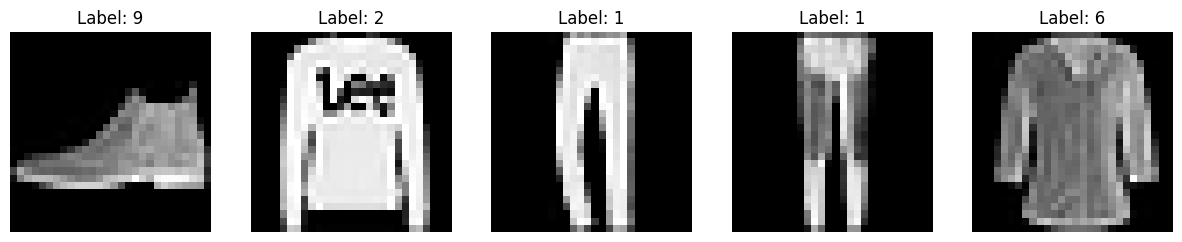

In [66]:
test_samples = [test[i][0] for i in range(5)]
test_labels = [test[i][1] for i in range(5)]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(test_samples[i].squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {test_labels[i]}")
    axes[i].axis('off')
plt.show()


In [67]:
test_samples = torch.stack(test_samples).to(device)
with torch.no_grad():
    output = f(test_samples)
    _, pred = torch.max(output, dim=1)

    for i in range(5):
        print(f"Predicted label: {pred[i].item()}")

Predicted label: 9
Predicted label: 2
Predicted label: 1
Predicted label: 1
Predicted label: 6
